# Intro to Statsmodels

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
import pandas as pd
import statsmodels.api as sm
df = sm.datasets.macrodata.load_pandas().data
df.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

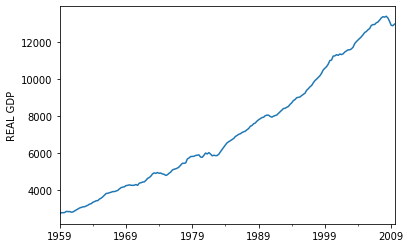

In [6]:
#plot the dateset
ax = df['realgdp'].plot()
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='REAL GDP');

In [7]:
# Hodrick-Prescott filter separates a time series yt into a treand component and a cyclical component
# lambda is a smoothing parameter, it handles variations in the growth rate of the trend component
# for quarterly data, default lambda value of 1600 is recommended. 6.25 for annual data, and 129,600 for monthly data
from statsmodels.tsa.filters.hp_filter import hpfilter

#tuple unpacking
gdp_cycle, gdp_trend = hpfilter(df['realgdp'], lamb=1600)
type(gdp_cycle)

pandas.core.series.Series

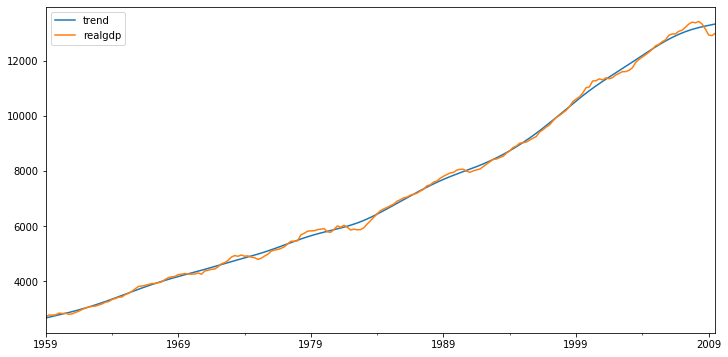

In [10]:
df['trend']=gdp_trend
df[['trend','realgdp']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)

# Error/Trend/Seasonality Models (ETS)

## Seasonal Decomposition

Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [12]:
airline = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


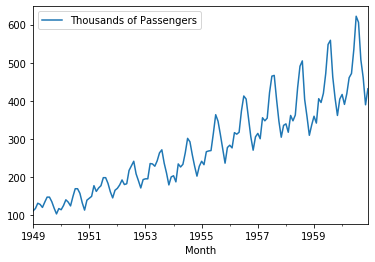

In [13]:
airline.plot();

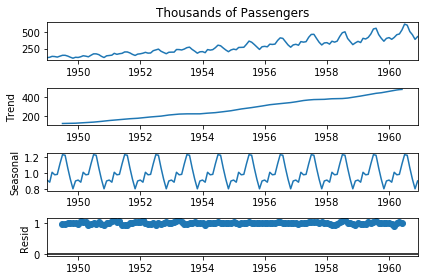

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

#based on plot above, the trend is multiplicative.
result = seasonal_decompose(airline['Thousands of Passengers'], model='mul')
result.plot();

# Moving Averages

## Simple Moving Averages (SMA)

In [19]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


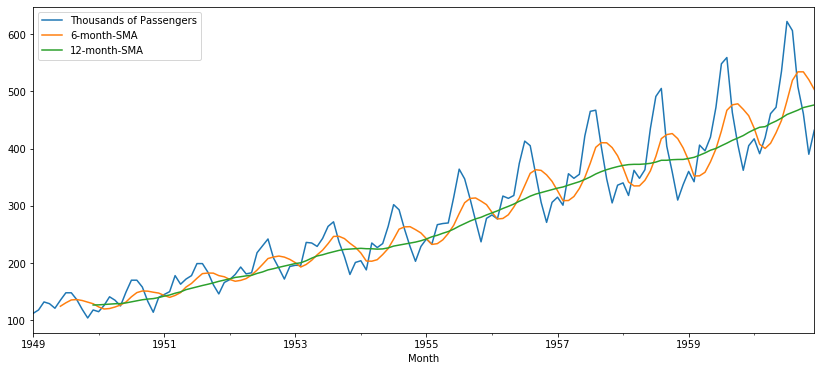

In [21]:
airline.plot(figsize=(14,6));

## Exponentially Weighted Moving Average (EWMA)

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}
 
 * <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

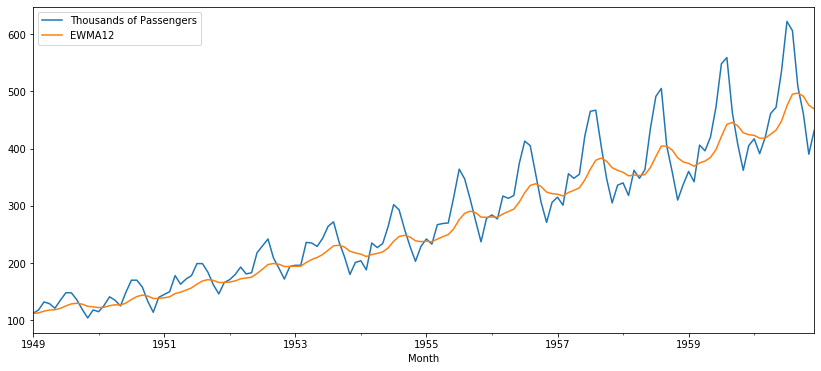

In [22]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()
airline[['Thousands of Passengers','EWMA12']].plot(figsize=(14,6));

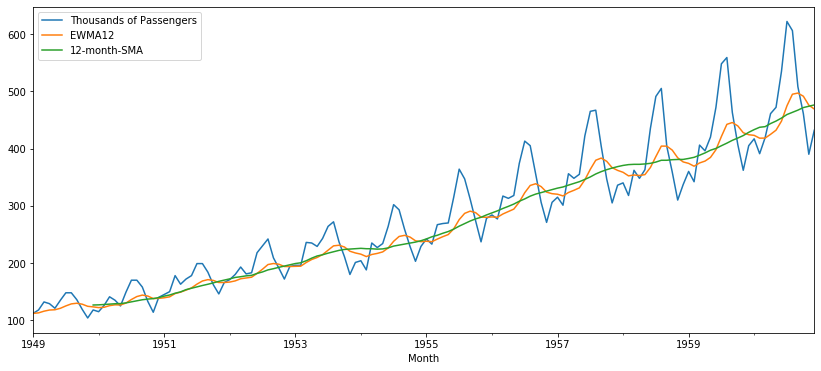

In [25]:
#Compare SMA to EWMA
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

The above example employed Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above.

## Holt-Winters Methods

In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
   

### Setting a DatetimeIndex Frequency

Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.

In [29]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

### Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. It performs the same calculation of the weighted moving average as the pandas .ewm() method

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()
#For some reason, when optimized=False is passed into .fit(), 
#the statsmodels SimpleExpSmoothing function shifts fitted values down one row. 
#We fix this by adding .shift(-1) after .fittedvalues
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


### Double Exponential Smoothing

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# additive seasonal adjustment
df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.237772
1949-02-01,118,112.923077,112.923077,120.237772
1949-03-01,132,115.857988,115.857988,134.237772
1949-04-01,129,117.879836,117.879836,131.237772
1949-05-01,121,118.359861,118.359861,123.237772


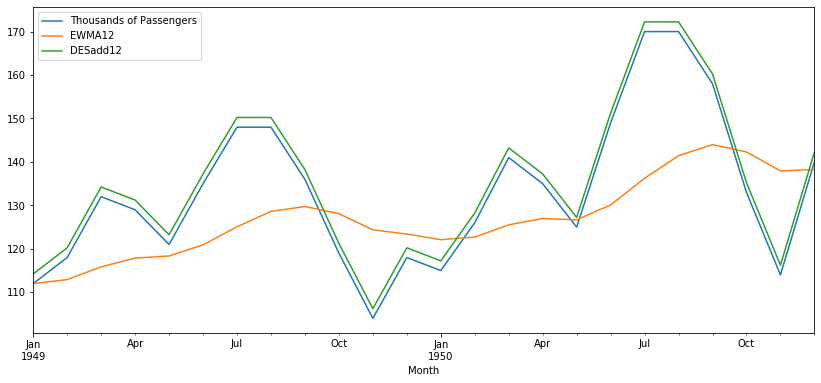

In [41]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.

In [34]:
# multiplicative seasonal adjustment
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.237772,112.049247
1949-02-01,118,112.923077,112.923077,120.237772,118.051885
1949-03-01,132,115.857988,115.857988,134.237772,132.058041
1949-04-01,129,117.879836,117.879836,131.237772,129.056722
1949-05-01,121,118.359861,118.359861,123.237772,121.053204


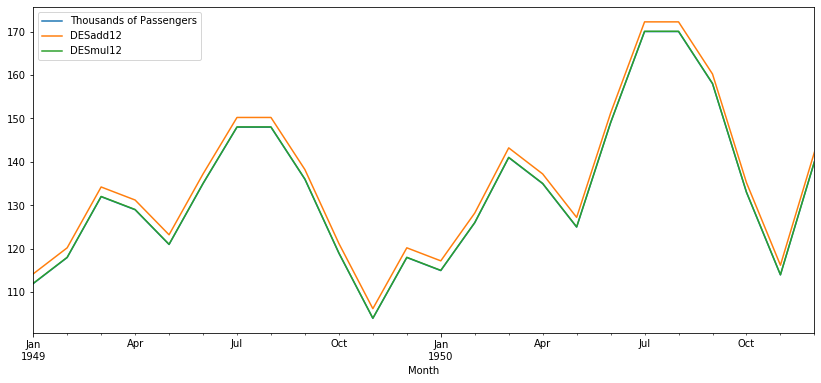

In [40]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

## Triple Exponential Smoothing

In [36]:
# Triple Exponential Smoothing.
# the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data.
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.237772,112.049247,113.081288
1949-02-01,118,112.923077,112.923077,120.237772,118.051885,120.550753
1949-03-01,132,115.857988,115.857988,134.237772,132.058041,135.527339
1949-04-01,129,117.879836,117.879836,131.237772,129.056722,133.155076
1949-05-01,121,118.359861,118.359861,123.237772,121.053204,125.656129


In [37]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.237772,112.049247,113.081288,111.608110
1949-02-01,118,112.923077,112.923077,120.237772,118.051885,120.550753,118.853687
1949-03-01,132,115.857988,115.857988,134.237772,132.058041,135.527339,133.343675
1949-04-01,129,117.879836,117.879836,131.237772,129.056722,133.155076,127.912641
1949-05-01,121,118.359861,118.359861,123.237772,121.053204,125.656129,120.991626


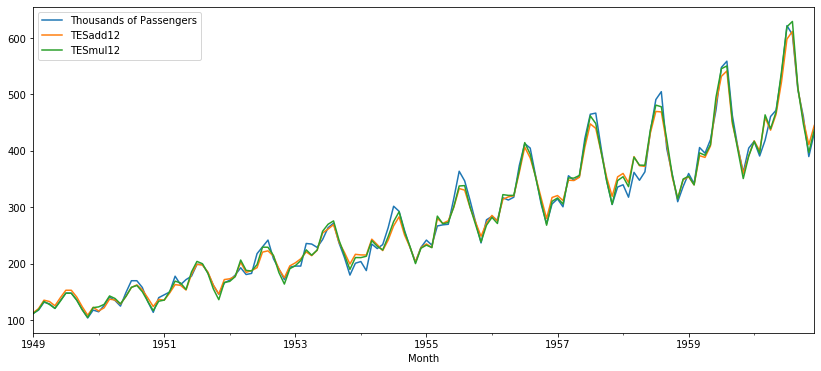

In [39]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

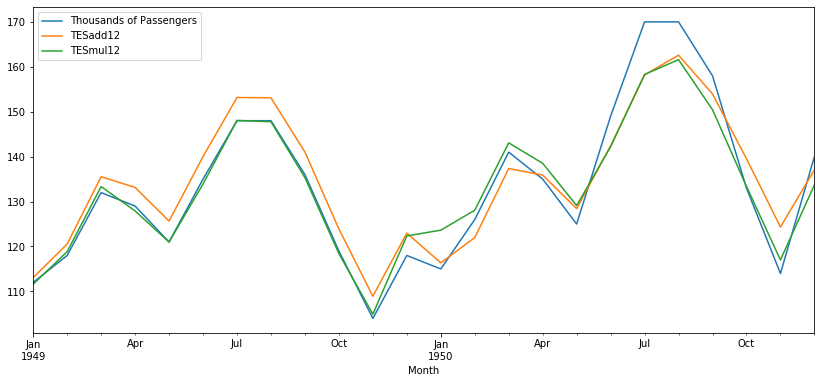

In [42]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - forecasting. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.